# STFT

In [ ]:
stft_data = np.zeros([1280,32,129,63]) 

for i in range(stft_data.shape[0]):
  xx = mne.time_frequency.stft(eeg_data[i],wsize=256) #eeg_data shape (1280,32,8064) (sample,channel,data)
  stft_data[i] = xx

In [ ]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,stft_data.shape[0],1)
np.random.shuffle(idx)
ts = int(train_size*stft_data.shape[0]) 
vs = int(val_size*stft_data.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [ ]:
x_train = stft_data[idx_train]
x_val =  stft_data[idx_val]
x_test = stft_data[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]

# DataLoader 

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
  """ x_train (896, 16, 129, 63)
      x_val (128, 16, 129, 63)
      x_test (256, 16, 129, 63)
      y_train (896,)
      y_val (128,)
      y_test (256,)  """
batch_size = 50
def dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = dataloader(x_train, y_train, batch_size)

valid_loader = dataloader(x_val, y_val, batch_size)

test_loader = dataloader(x_test, y_test, batch_size)

# Conv2d model

In [ ]:
num_epochs = 50
num_classes = 2
learning_rate = 0.001

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        

        #stft_data.shape[1] = number of channel
        self.layer1 = nn.Sequential(
            nn.Conv2d(stft_data.shape[1], 32, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(128*16*7, num_classes)
        self.drop_out = nn.Dropout(p=0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        out = self.drop_out(out)

        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [ ]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [ ]:
model = ConvNet(num_classes)
model.apply(initialize_weights)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=14336, out_features=2, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train Test 

In [ ]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    correct = (predicted == y).sum()
    acc = correct / y.size(0)
    return acc

In [ ]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
                
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 


            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 2.388 | Train Acc: 49.36%
	 Val. Loss: 1.077 |  Val. Acc: 52.67%
Epoch: 02 | Train Loss: 0.817 | Train Acc: 54.22%
	 Val. Loss: 0.766 |  Val. Acc: 55.05%
Epoch: 03 | Train Loss: 0.866 | Train Acc: 52.01%
	 Val. Loss: 0.836 |  Val. Acc: 49.10%
Epoch: 04 | Train Loss: 0.885 | Train Acc: 51.71%
	 Val. Loss: 0.724 |  Val. Acc: 52.52%
Epoch: 05 | Train Loss: 0.762 | Train Acc: 56.85%
	 Val. Loss: 0.781 |  Val. Acc: 53.57%
Epoch: 06 | Train Loss: 0.750 | Train Acc: 56.51%
	 Val. Loss: 0.735 |  Val. Acc: 53.19%
Epoch: 07 | Train Loss: 0.779 | Train Acc: 55.59%
	 Val. Loss: 0.997 |  Val. Acc: 51.86%
Epoch: 08 | Train Loss: 0.865 | Train Acc: 52.57%
	 Val. Loss: 1.041 |  Val. Acc: 53.43%
Epoch: 09 | Train Loss: 0.784 | Train Acc: 54.74%
	 Val. Loss: 0.809 |  Val. Acc: 53.29%
Epoch: 10 | Train Loss: 0.728 | Train Acc: 55.37%
	 Val. Loss: 0.733 |  Val. Acc: 58.62%
Epoch: 11 | Train Loss: 0.825 | Train Acc: 54.72%
	 Val. Loss: 0.756 |  Val. Acc: 54.38%
Epoch: 12 | Train Los

Text(0, 0.5, 'loss')

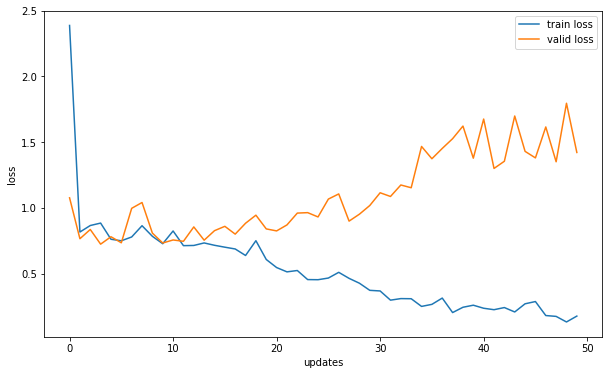

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

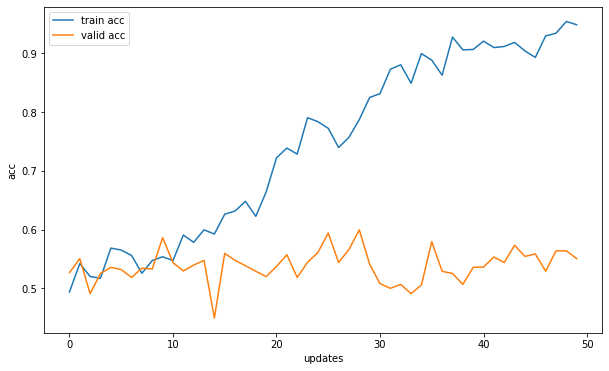

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.797 | Test Acc: 48.56%
